In [26]:
import pandas as pd
import numpy as np
from helper_functions import mag, angle
import dlib
import cv2
import matplotlib.pyplot as plt
import imutils
from imutils import face_utils
import random
from math import pi

# Constants

In [27]:
data_path = '../dataset/'
model_path = '../models/'

# Importing Data

### Load CSV

In [28]:
moods = ["anger","disgust","fear","happiness","sadness","surprise","neutral"]
df = pd.read_csv(data_path + 'fer2013/fer2013.csv')
df["vectors"], df["coords"] = ['']*df.shape[0], ['']*df.shape[0]

In [29]:
df.head(10)

,emotion,pixels,Usage,vectors,coords
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training,,
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training,,
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training,,
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training,,
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training,,
5,2,55 55 55 55 55 54 60 68 54 85 151 163 170 179 ...,Training,,
6,4,20 17 19 21 25 38 42 42 46 54 56 62 63 66 82 1...,Training,,
7,3,77 78 79 79 78 75 60 55 47 48 58 73 77 79 57 5...,Training,,
8,3,85 84 90 121 101 102 133 153 153 169 177 189 1...,Training,,
9,2,255 254 255 254 254 179 122 107 95 124 149 150...,Training,,


In [6]:
%%time
pixels = []
for row in df.pixels:
    pixels.append([int(k) for k in row.split(' ')])
X = np.array(pixels)
X = X.reshape(X.shape[0], 48, 48)
Y = df.emotion
print(X.shape, Y.shape)

(35887, 48, 48) (35887,)
CPU times: total: 12.2 s
Wall time: 12.4 s


# Import Predictor

In [30]:
predictor = dlib.shape_predictor('../shape_predictor_68_face_landmarks.dat')

# Feature Extraction

Processed: 1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 10000, 11000, 12000, 13000, 14000, 15000, 16000, 17000, 18000, 19000, 20000, 21000, 22000, 23000, 24000, 25000, 26000, 27000, 28000, 29000, 30000, 31000, 32000, 33000, 34000, 35000.

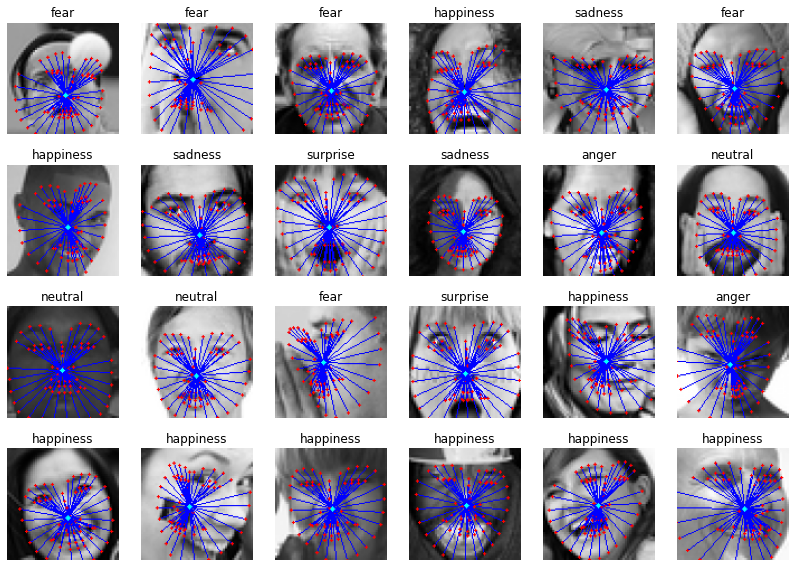

CPU times: total: 2min 32s
Wall time: 2min 33s


In [31]:
%%time
width = 100
rand = random.sample(range(df.shape[0]), 24)
fig = plt.figure(figsize=(14, 10))

print('Processed: ', end='')
for i in range(len(X)):
    if not (i+1) % 1000:
        print(i+1, end='.' if i+1==len(X)//1000*1000 else ', ')
    vectors, coords = [], []
    
    image = np.uint8(X[i])
    image = imutils.resize(image, width=width)
    gray = cv2.equalizeHist(image)    
    image = np.dstack((image,image,image))
    
    # convert canvas to bounding box
    rect = dlib.rectangle(left=0, top=0, right=width-1, bottom=width-1)
    
    # determine facial landmarks for face region
    shape = predictor(gray, rect) 
    shape = face_utils.shape_to_np(shape)

    # get center of gravity (COG)
    cog = tuple(shape.mean(axis=0).astype(int)) 

    # draw (x,y)-coordinates for the facial landmarks on image
    for (x,y) in shape:
        cv2.line(image, (x,y), cog, (0,0,255), 1) # draw vector lines
        cv2.circle(image, (x,y), 1, (255,0,0), -1) # image, center-coords, radius, colour, thickness(fill)
        cv2.circle(image, cog, 2, (0,255,255), -1)
        vectors.append([mag(cog, (x,y)), angle(cog, (x,y))])
        coords.append([x,y])
        
    if i in rand:        
        fig.add_subplot(4, 6, rand.index(i)+1)
        plt.title(moods[Y[i]])
        plt.axis("off")
        plt.imshow(image)
            
    # store inputs in dataset
    vectors = np.array(vectors)
    vectors[:,0] /= max(vectors[:,0]) # normalize magnitudes
    vectors[:,1] = (vectors[:,1] + pi) / (2*pi) # normalize direction
    vectors = vectors.reshape(-1)
    if len(vectors) == 136:
        df.loc[i, 'vectors'] = ' '.join(str(e) for e in vectors)
    
    coords = np.array(coords)
    coords -= np.c_[min(coords[:,0]), min(coords[:,1])]
    coords = coords / np.c_[max(coords[:,0]), max(coords[:,1])]
    coords = coords.reshape(-1)
    if len(coords) == 136:
        df.loc[i, 'coords'] = ' '.join(str(e) for e in coords)

plt.show()

# Filter Data

In [33]:
df = df[(df['vectors']!='') & (df['coords']!='')]
print(df.shape[0])
display(df.head())

35887


,emotion,pixels,Usage,vectors,coords
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training,1.0 0.0855595721559356 0.908951992362738 0.053...,0.0 0.05194805194805195 0.0 0.2207792207792207...
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training,0.9097354562079145 0.03439099146890885 0.84523...,0.0 0.36363636363636365 0.024390243902439025 0...
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training,0.8700982144280447 0.14542327599970098 0.76867...,0.07228915662650602 0.05 0.03614457831325301 0...
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training,0.5993885222413324 0.083143088445855 0.5277248...,0.043010752688172046 0.2222222222222222 0.0537...
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training,0.9739085450273313 0.06621872273103259 0.88574...,0.0 0.25 0.012345679012345678 0.39473684210526...


# Save Data

In [34]:
df.to_csv(data_path + 'fer2013/vector_coords_norm.csv')